# Data Scientist Challenge:
Developed by Lorant Romano
__________________________

Importando libs iniciais

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time

pd.get_option("display.max_columns", 1000)
plt.style.use('seaborn-notebook')
%matplotlib inline

In [2]:
#lendo os dados de teste e treino
df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test_no_label.csv')

# EDA(Exploratory Data Analisys)
A princípio iremos analisar as variáveis (features) isoladamente a fim de encontrar outliers, valores faltantes etc... Após, iremos iniciar a limpeza dos dados (Data Cleaning)

In [ ]:
df_train.info()

In [ ]:
df_train.head()

In [ ]:
df_test.info()

In [ ]:
df_test.head()

Existe 146.082 observações e 16 colunas no set de treino, enquanto, no set de teste, existem 48.695 observações e 
15 colunas.

A coluna faltante no set de treinos é "country_destination" que, no caso, é o target desejado.
Percebesse que cerca de 43% dos dados da coluna "age" são desconhecidos ("NA"). Isso pode afetar o resultado final do modelo
e devem ser estudadas algumas técnicas de para melhor classificação desses dados.

# Análise Univariavel

## Datas


In [3]:
#Tranformando variáveis tipo "Object" em "Datetime"
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['timestamp_first_active'] = df_train['timestamp_first_active'].map(lambda x: int(x/1000000))
df_train['timestamp_first_active'] = pd.to_datetime(df_train['timestamp_first_active'], format= '%Y%m%d')

df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])
df_test['timestamp_first_active'] = df_test['timestamp_first_active'].map(lambda x: int(x/1000000))
df_test['timestamp_first_active'] = pd.to_datetime(df_test['timestamp_first_active'], format= '%Y%m%d')

In [4]:
#Criando e explorando a partir das datas existentes
df_train['tfa_dac'] = df_train['date_account_created'] - df_train['timestamp_first_active']
print('Diferença entre Data de ativação e Data de Criação')
print(df_train['tfa_dac'].describe())
print('Informações de Data de ativação')
print(df_train['timestamp_first_active'].describe())
print('Informações de Data de Criação')
print(df_train['date_account_created'].describe())
print('% de dias maiores que zero entre a Data de Criação e a Data de Ativação: {}%'
      .format(((df_train['tfa_dac']> '0 days').sum()/len(df_train['tfa_dac']))*100))


Diferença entre Data de ativação e Data de Criação
count                     146082
mean      0 days 05:46:18.182116
std      12 days 16:30:07.221193
min              0 days 00:00:00
25%              0 days 00:00:00
50%              0 days 00:00:00
75%              0 days 00:00:00
max           1456 days 00:00:00
Name: tfa_dac, dtype: object
Informações de Data de ativação
count                  146082
unique                   1632
top       2014-05-13 00:00:00
freq                      466
first     2009-05-23 00:00:00
last      2014-06-30 00:00:00
Name: timestamp_first_active, dtype: object
Informações de Data de Criação
count                  146082
unique                   1629
top       2014-05-13 00:00:00
freq                      466
first     2010-01-02 00:00:00
last      2014-06-30 00:00:00
Name: date_account_created, dtype: object
% de dias maiores que zero entre a Data de Criação e a Data de Ativação: 0.07666926794540052%


Verificou-se que em torno de 0,08% das datas existem alguma diferença. 
Pode-se concluir que não exitem diferença significativa entre datas.

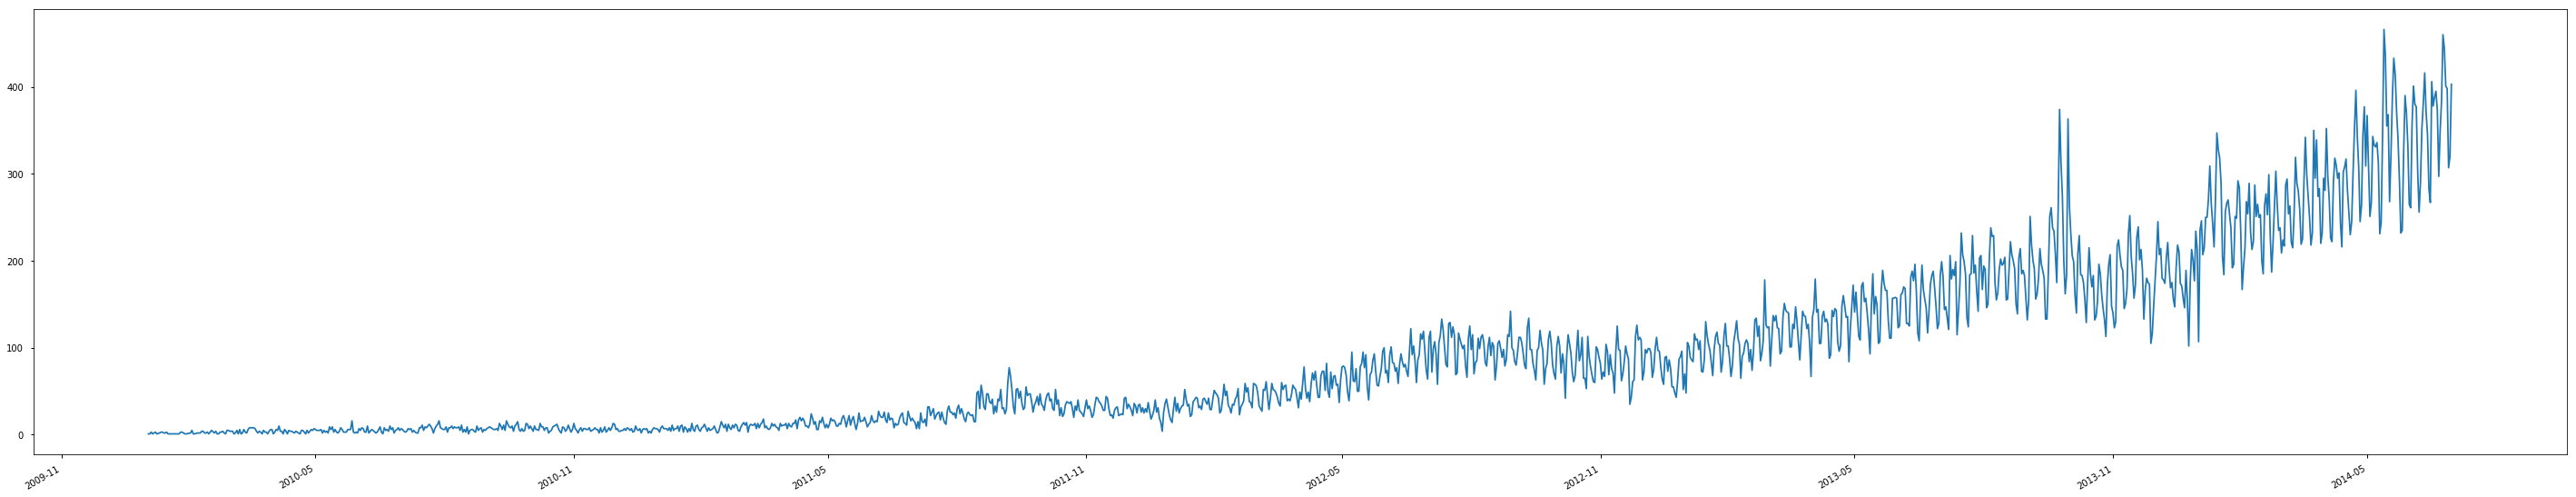

In [5]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize =(50,10))
df_train['date_account_created'].value_counts().plot(kind='line', ax=axes)
fig.autofmt_xdate()
plt.show()

In [6]:
df_train['DIA'] = df_train['date_account_created'].map(lambda x: x.day)
df_train['MES'] = df_train['date_account_created'].map(lambda x: x.month)
df_train['ANO'] = df_train['date_account_created'].map(lambda x: x.year)
df_train['DIASEMANA'] = df_train['date_account_created'].map(lambda x: x.strftime("%A"))

df_test['DIA'] = df_test['date_account_created'].map(lambda x: x.day)
df_test['MES'] = df_test['date_account_created'].map(lambda x: x.month)
df_test['ANO'] = df_test['date_account_created'].map(lambda x: x.year)
df_test['DIASEMANA'] = df_test['date_account_created'].map(lambda x: x.strftime("%A"))

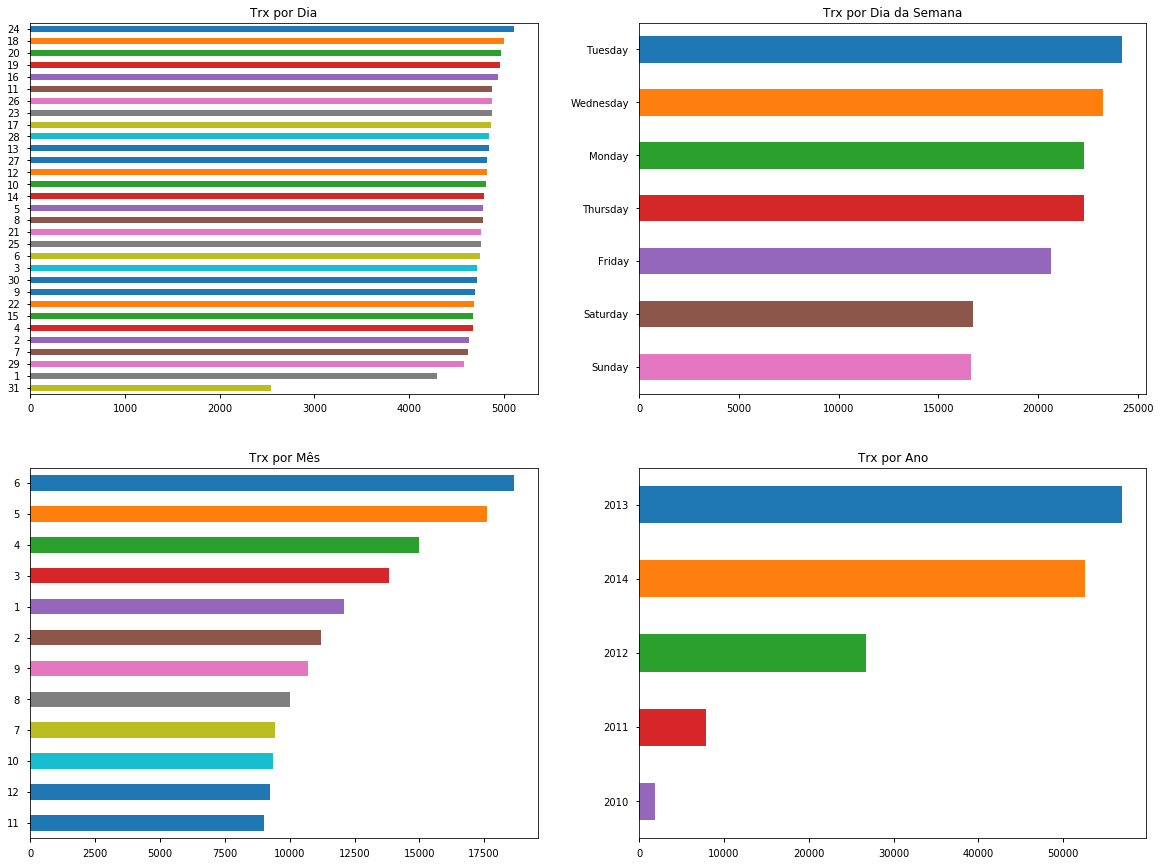

In [7]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize =(20,15))
df_train['DIA'].value_counts().plot(kind='barh', ax=ax1, title = 'Trx por Dia')
df_train['DIASEMANA'].value_counts().plot(kind='barh', ax=ax2, title = 'Trx por Dia da Semana')
df_train['MES'].value_counts().plot(kind='barh', ax=ax3, title = 'Trx por Mês')
df_train['ANO'].value_counts().plot(kind='barh', ax=ax4, title = 'Trx por Ano')
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()
plt.show()

* Como esperado, o dia 31 é aquele onte vemos menos transações 

* Verificamos que Terça-feira é o dia em que mais existem transações, enquanto no final de semana (Sábado e Domingo) 
esse número é relativamente menor. 

* Os meses que antecedem as férias de verão no hemisfério Norte (Abril, Maio e Junho) são os que apresentam maior busca 

* Verifica-se um crescimento bastante agressivo no número de transações entre os anos de 2011 e 2013, com uma queda em 2014

## Idade

In [8]:
df_train['age'].describe()

count    83469.000000
mean        49.266314
std        153.026081
min          1.000000
25%         28.000000
50%         34.000000
75%         43.000000
max       2014.000000
Name: age, dtype: float64

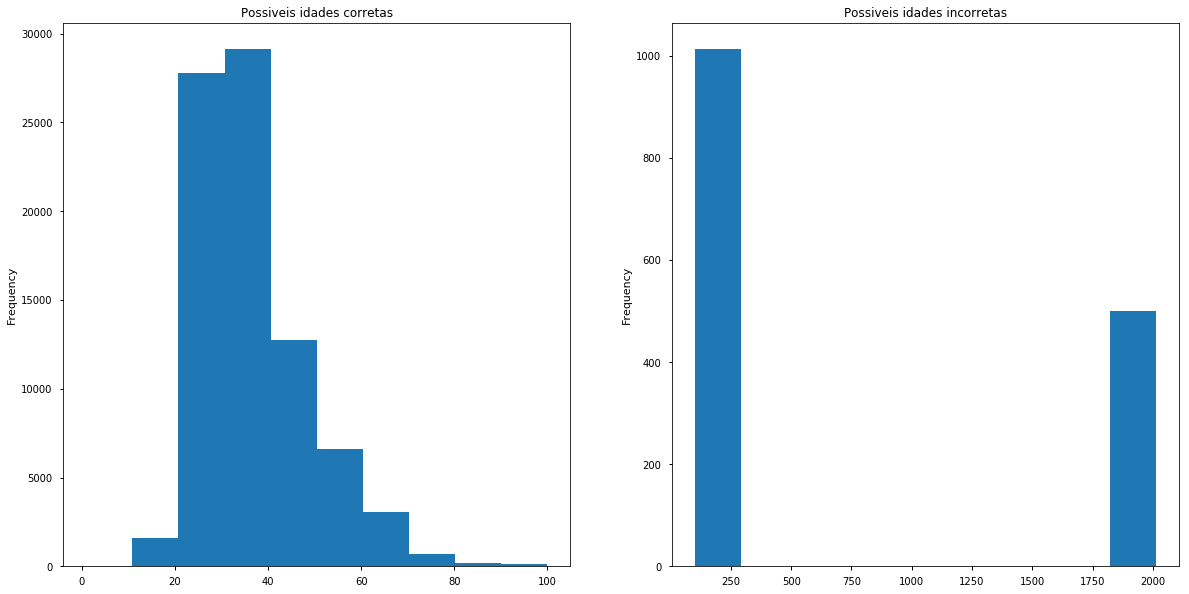

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
df_train.age[df_train['age']<=100].plot(kind='hist', ax=ax1, title = 'Possiveis idades corretas')
df_train.age[df_train['age']>100].plot(kind='hist', ax=ax2, title = 'Possiveis idades incorretas')
plt.show()


* Podemos observar uma quantidade razoavel de idades fora do possivel. Possivelmente por erro de digitação ou informações não claras na fonte.

In [10]:
#Função que irá determinar com qual idade iremos preencher o campo
def idade(numero):
    if (numero > 1925) & (numero <  1997):
        idade = 2014 - numero
    elif (numero > 14) & (numero < 100):
        idade = numero
    else:
        idade = -1
    return idade

In [11]:
df_train['age'] = df_train['age'].map(idade)
df_test['age'] = df_test['age'].map(idade)

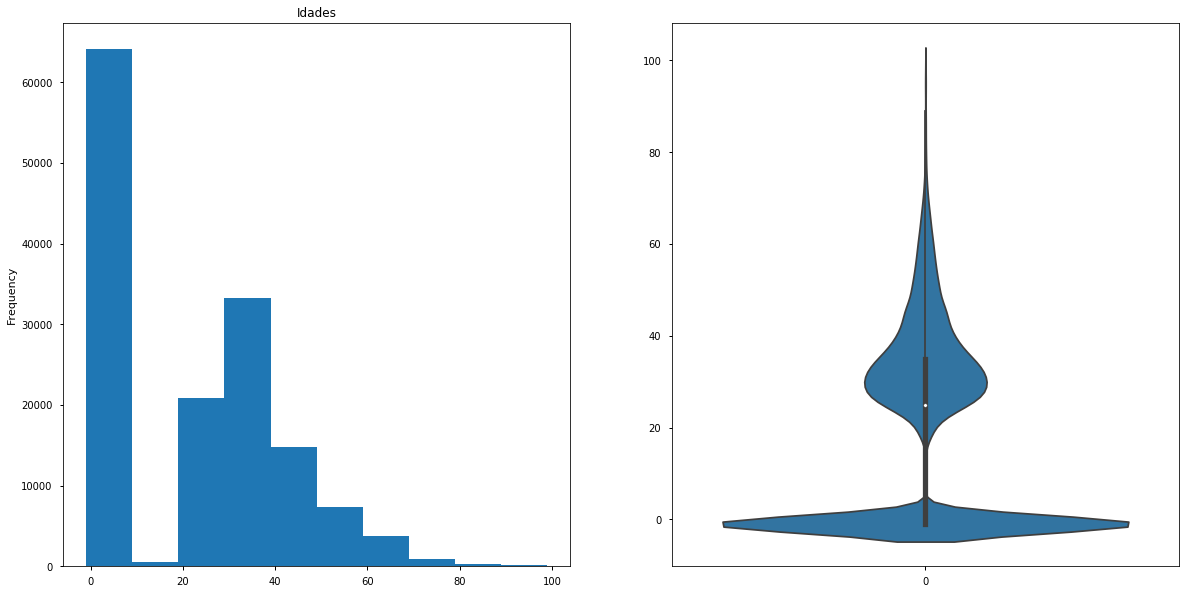

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
df_train.age.plot(kind='hist', ax=ax1, title = 'Idades')
sns.violinplot(data = df_train['age'] , title = 'Idades')
plt.show()

* Após processar as idade, obtemos as possiveis idades reais.
* O publico médio se encontra entre 20 a 40 anos.

## Gênero

In [13]:
print(df_train['gender'].describe())
print('Unicos')
print(df_train['gender'].unique())

count        146082
unique            4
top       -unknown-
freq          67053
Name: gender, dtype: object
Unicos
['-unknown-' 'FEMALE' 'MALE' 'OTHER']


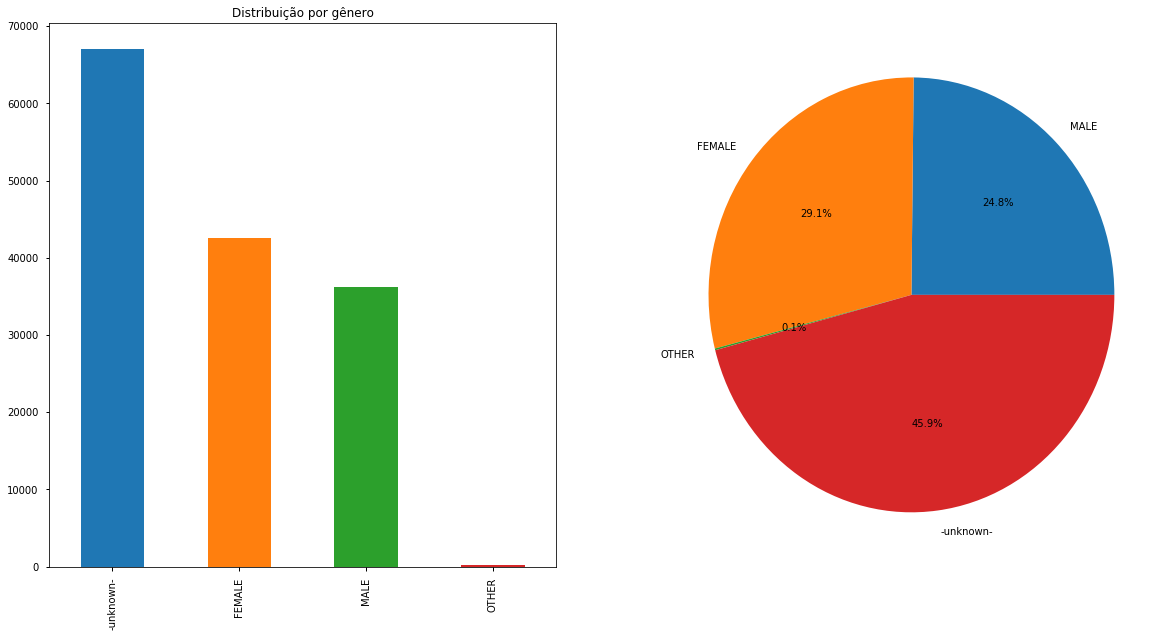

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize =(20,10))
legendas = ['MALE','FEMALE','OTHER', '-unknown-']
percent = []
for legenda in legendas:
    percent.append((df_train['gender'] == legenda).sum()/len(df_train['gender']))
df_train['gender'].value_counts().plot(kind='bar', ax=ax1, title = 'Distribuição por gênero')
ax2.pie(x = percent, labels = legendas, autopct='%1.1f%%')
plt.show()

## Demais Variaveis Categoricas

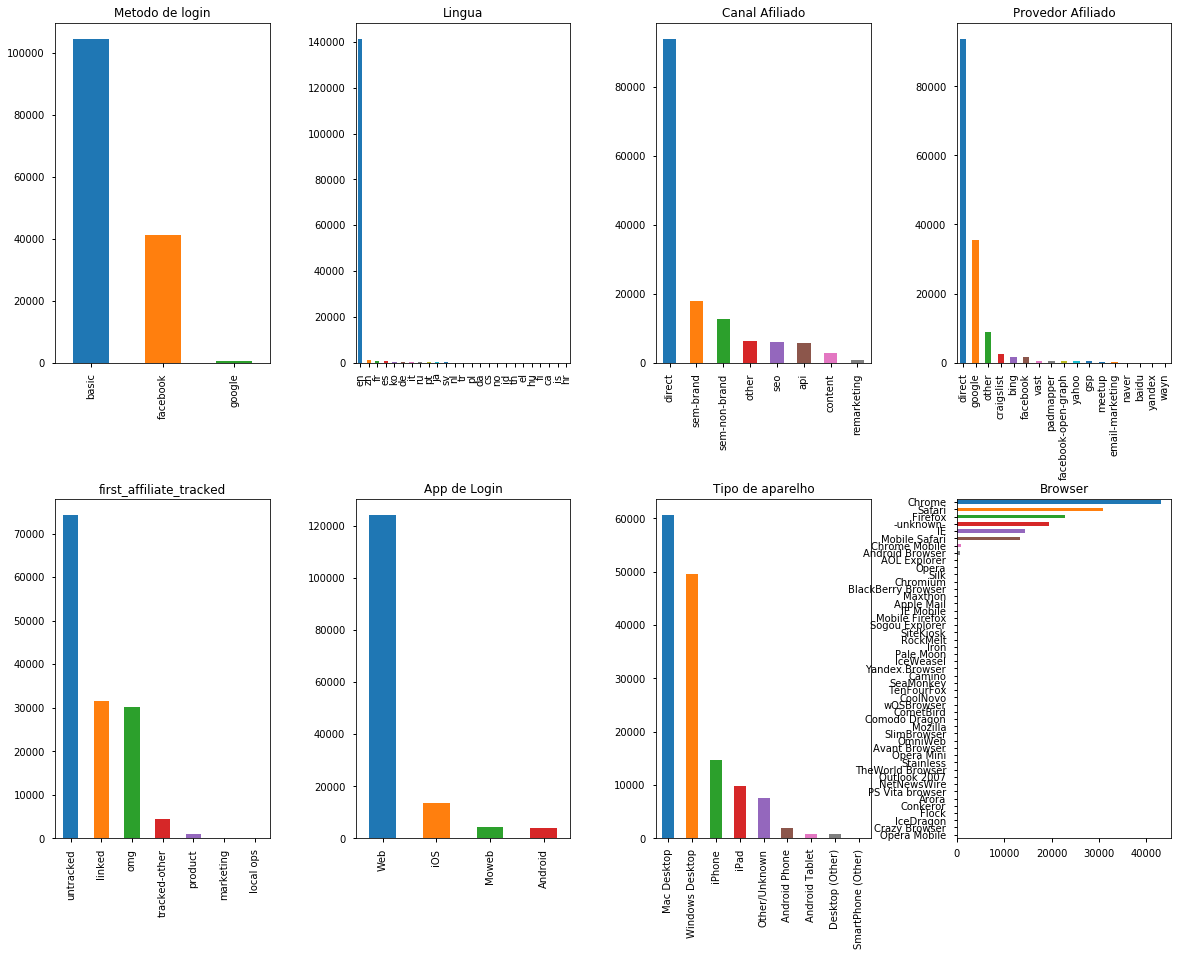

In [15]:
fig, ((ax1, ax2, ax3, ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
df_train['signup_method'].value_counts().plot(kind='bar', ax=ax1, title = 'Metodo de login')
df_train['language'].value_counts().plot(kind='bar', ax=ax2, title = 'Lingua')
df_train['affiliate_channel'].value_counts().plot(kind='bar', ax=ax3, title = 'Canal Afiliado')
df_train['affiliate_provider'].value_counts().plot(kind='bar', ax=ax4, title = 'Provedor Afiliado')
df_train['first_affiliate_tracked'].value_counts().plot(kind='bar', ax=ax5, title = 'first_affiliate_tracked')
df_train['signup_app'].value_counts().plot(kind='bar', ax=ax6, title = 'App de Login')
df_train['first_device_type'].value_counts().plot(kind='bar', ax=ax7, title = 'Tipo de aparelho')
df_train['first_browser'].value_counts().plot(kind='barh', ax=ax8, title = 'Browser')

ax8.invert_yaxis()

* Analises importantes:
    - A maioria das pessoas faz o login usando user e senha criadas no propio site ("basic")
    - Maioria absoluta dos usuarios tem como lingua a inglesa ("EN")
    - Os canais "Semi-Brand" e "Semi-no-brand" aumentam os acessos ao site 
    - O "Google" é o principal provedor afiliado
    - A principal forma de acesso é a "Web"
    - Os Desktops são os principais meios de acesso
    - Os principais Browsers do mercado tambem são os mais utilizados para acessar o site

## Destino

In [16]:
print(df_train['country_destination'].describe())
print('Unicos')
print(df_train['country_destination'].unique())

count     146082
unique         4
top          NDF
freq       93383
Name: country_destination, dtype: object
Unicos
['NDF' 'FR' 'US' 'IT']


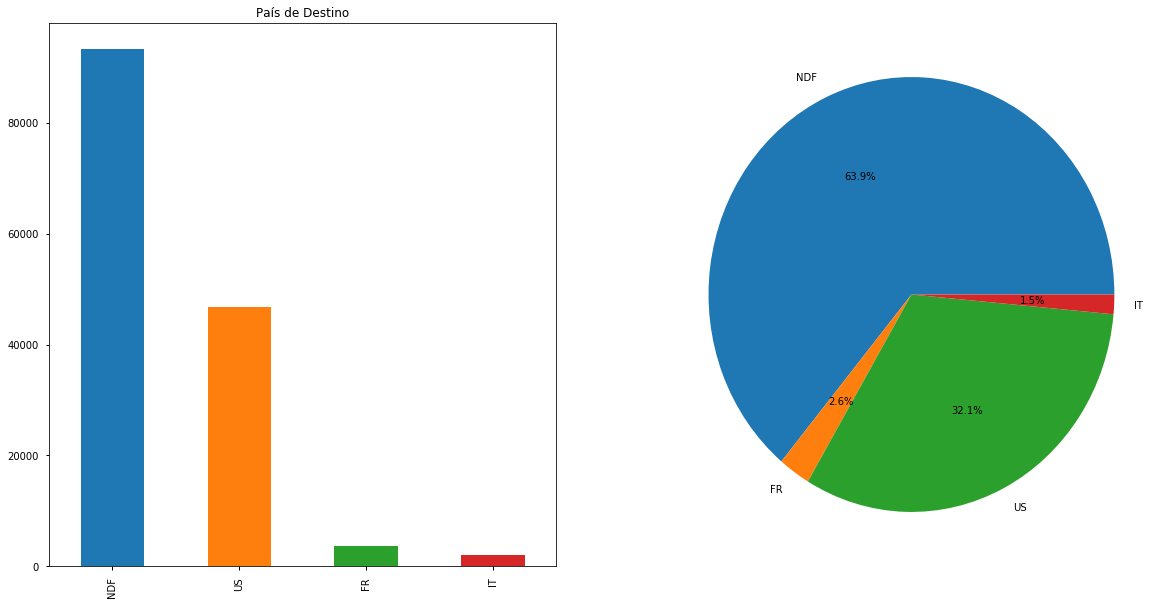

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize =(20,10))
paises = df_train['country_destination'].unique()
legendas = []
for pais in paises:
    legendas.append(pais)
percent = []
for legenda in legendas:
    percent.append((df_train['country_destination'] == legenda).sum()/len(df_train['country_destination']))
df_train['country_destination'].value_counts().plot(kind='bar', ax=ax1, title = 'País de Destino')
ax2.pie(x = percent, labels = legendas, autopct='%1.1f%%')
plt.show()

* Podemos verificar um desbalanceamento entre os possiveis Targets, isso pode prejudicar o resultado do modelo e devemos utilizar algumas ferramentas e tecnicas para minimizar os efeitos do problema.

# Analise Bivariavel

### DATA x Destinos

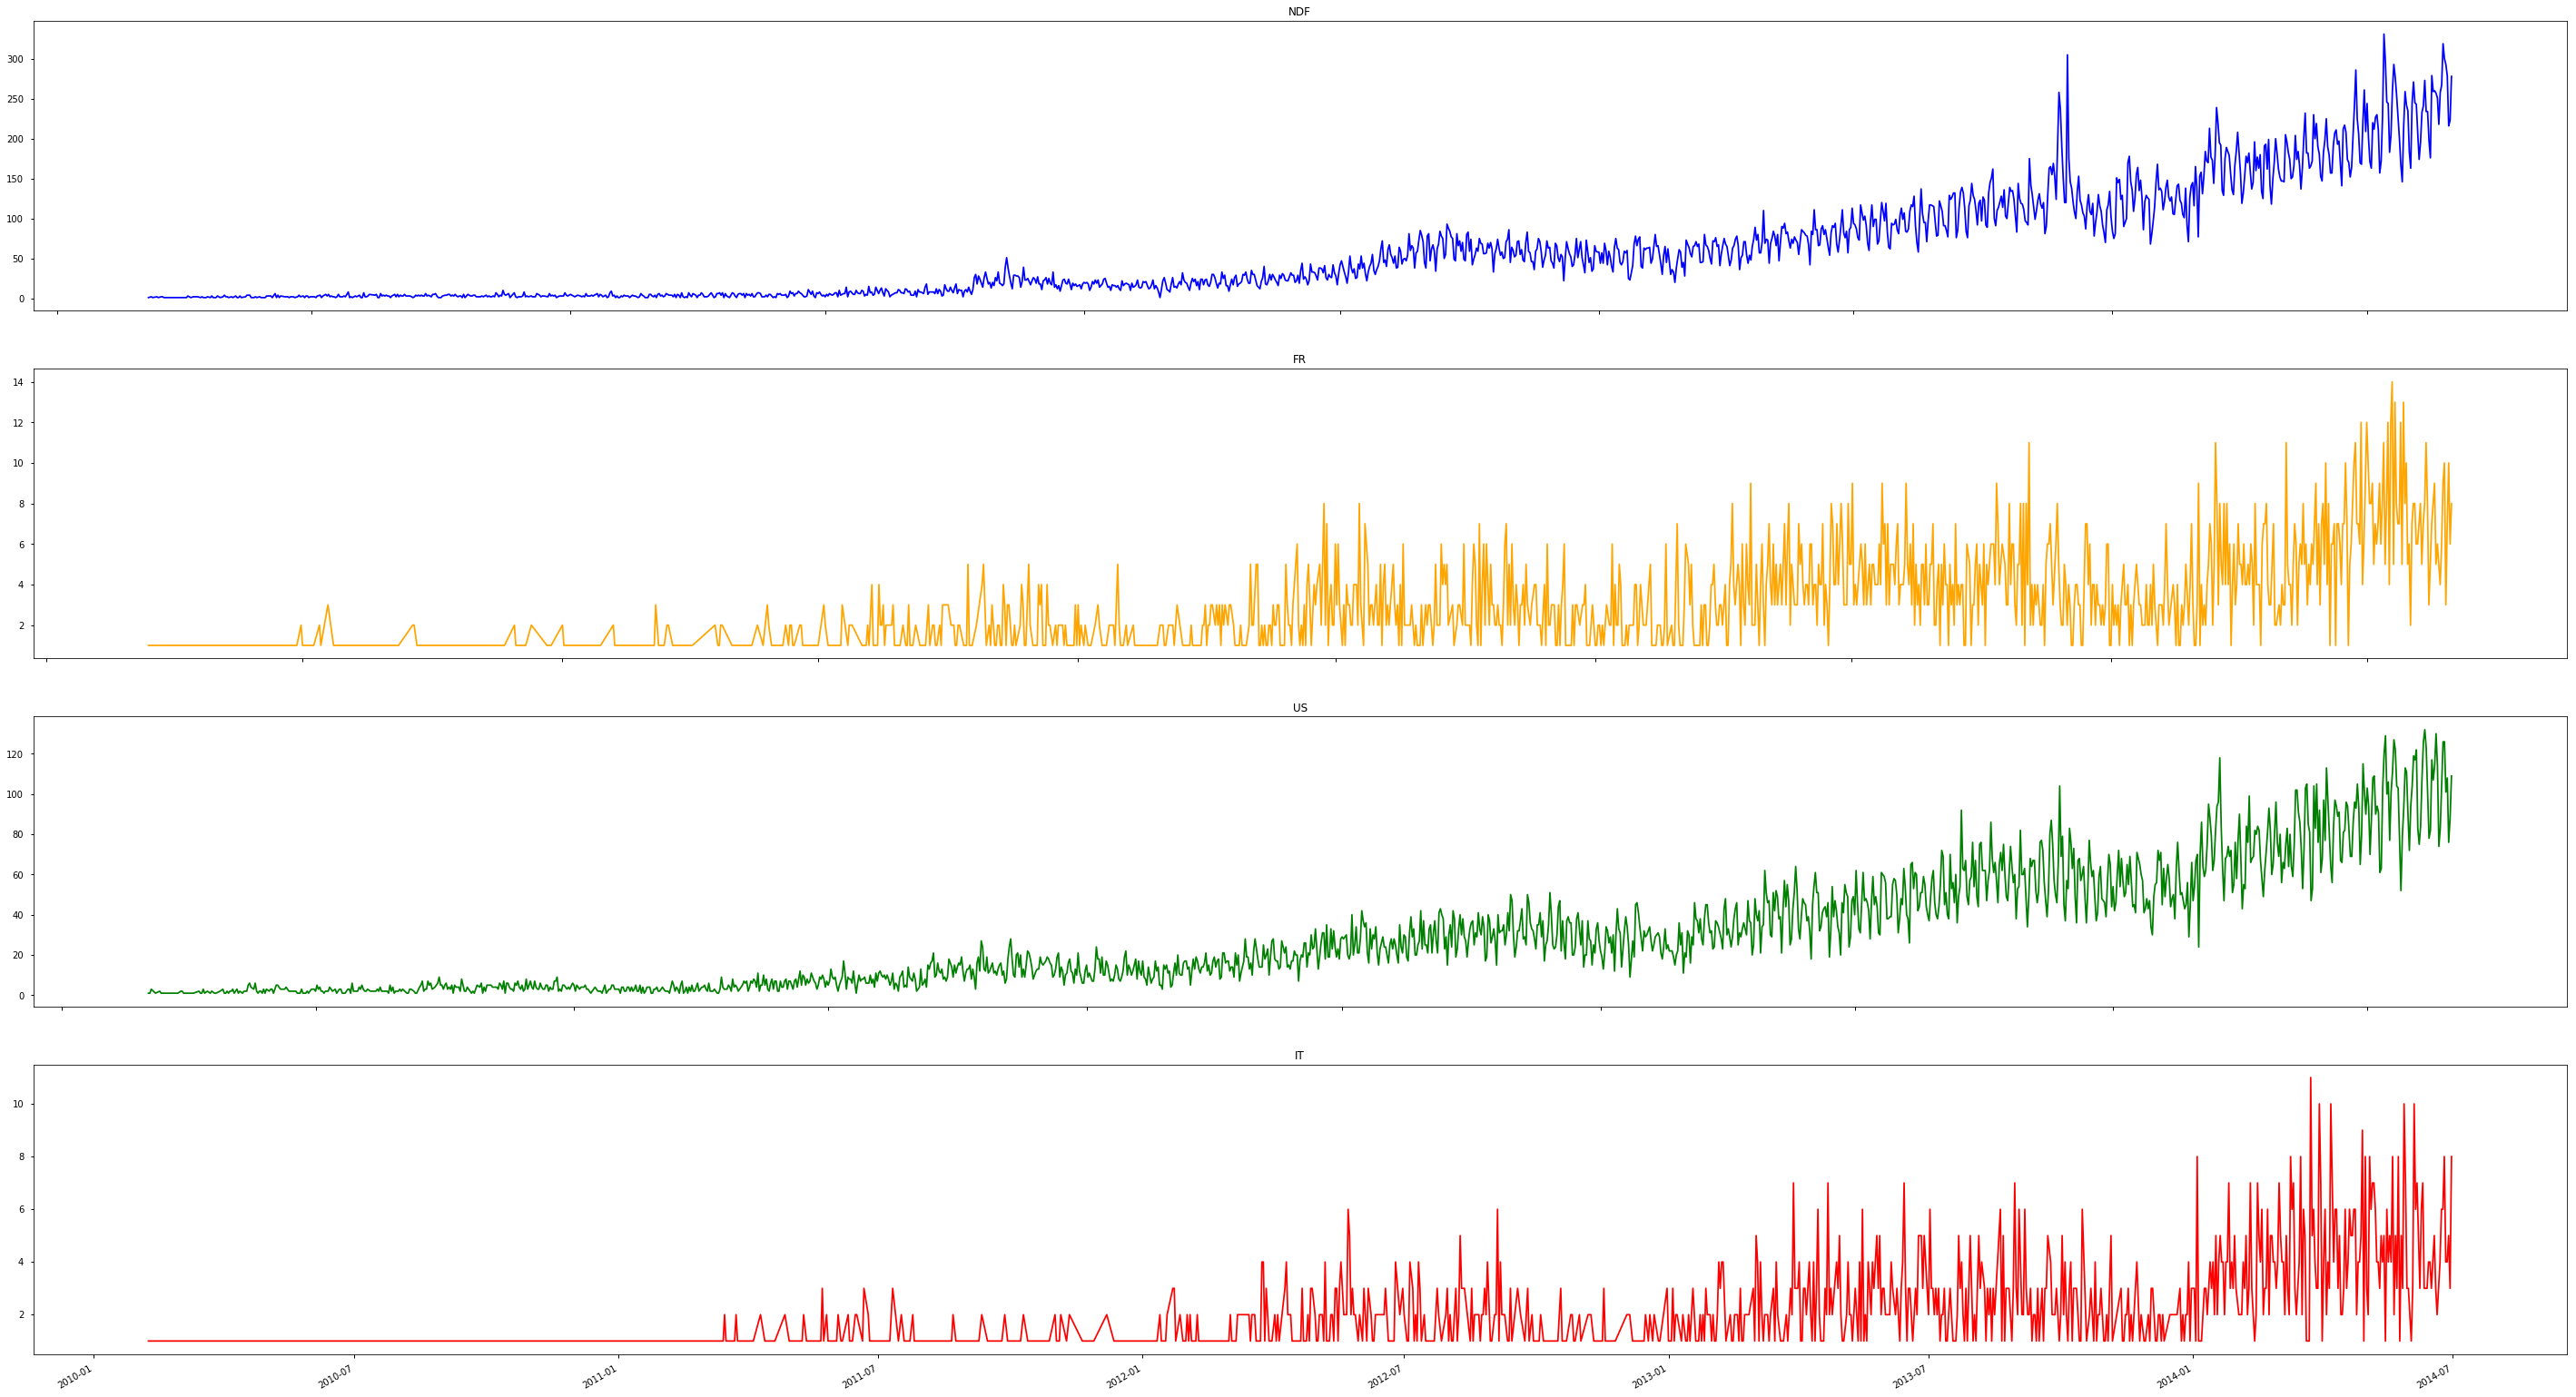

In [18]:
fig, ((ax1),(ax2),(ax3),(ax4)) = plt.subplots(nrows = 4, ncols = 1, figsize =(50,30))
c = ['blue','orange','green','red']
df_train['date_account_created'][df_train['country_destination'] == paises[0]].value_counts().plot(
    kind='line', ax=ax1, color = c[0], title = paises[0])
df_train['date_account_created'][df_train['country_destination'] == paises[1]].value_counts().plot(
    kind='line', ax=ax2, color = c[1], title = paises[1])
df_train['date_account_created'][df_train['country_destination'] == paises[2]].value_counts().plot(
    kind='line', ax=ax3, color = c[2], title = paises[2])
df_train['date_account_created'][df_train['country_destination'] == paises[3]].value_counts().plot(
    kind='line', ax=ax4, color = c[3], title = paises[3])
fig.autofmt_xdate()
plt.show()

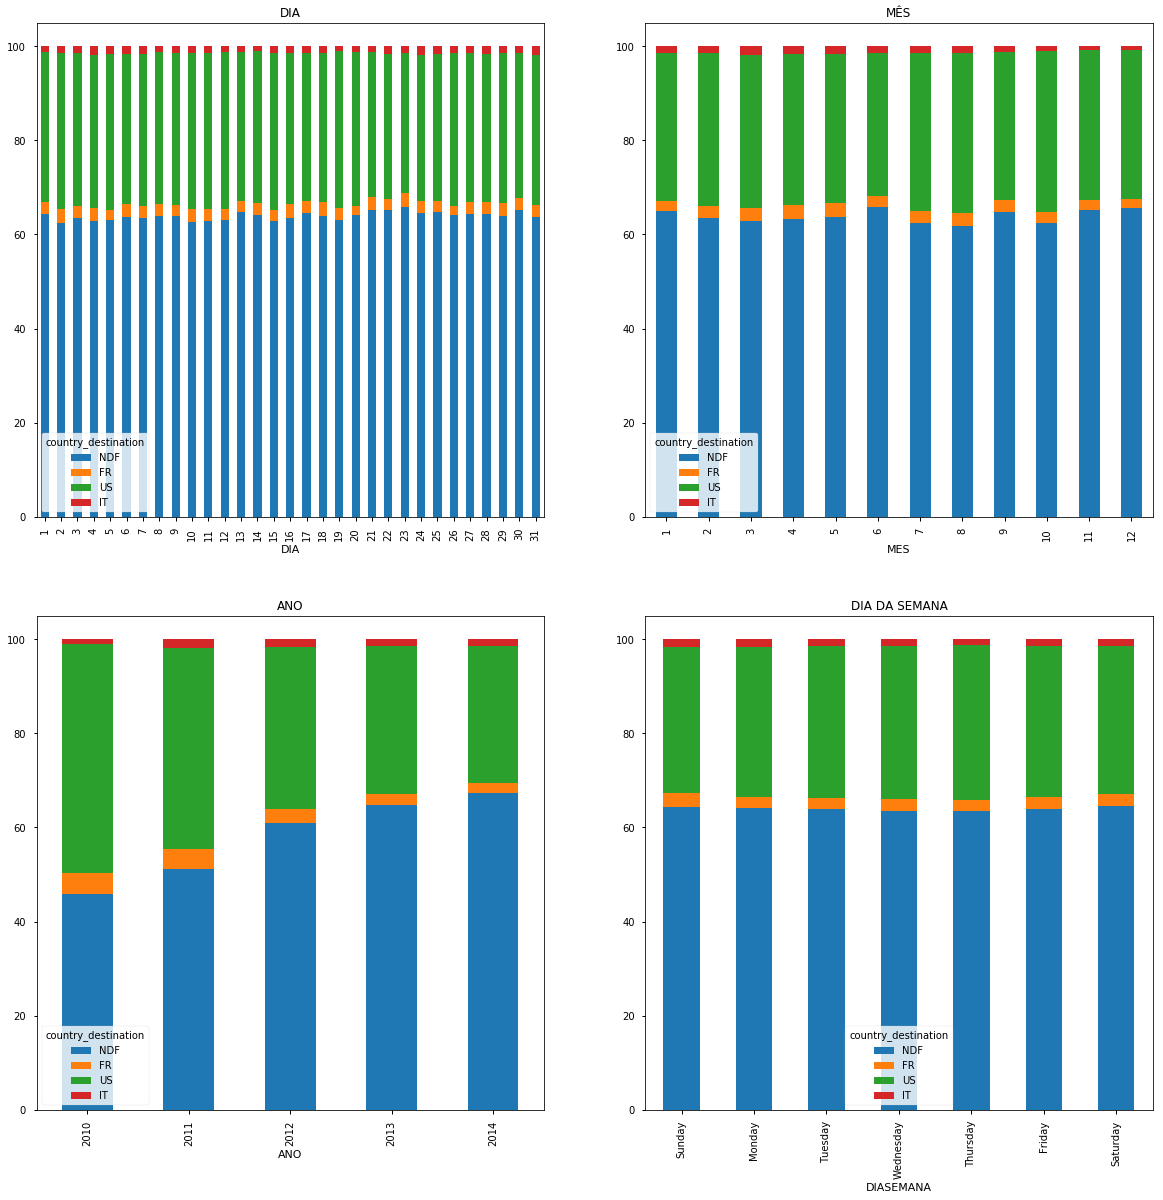

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))

ctab = pd.crosstab([df_train['DIA']], df_train.country_destination).apply(lambda x: (x/x.sum())*100, axis=1)
ctab[paises].plot(kind='bar', stacked = True, ax = ax1, title = 'DIA')
ctab = pd.crosstab([df_train['MES']], df_train.country_destination).apply(lambda x: (x/x.sum())*100, axis=1)
ctab[paises].plot(kind='bar', stacked = True, ax = ax2, title = 'MÊS')
ctab = pd.crosstab([df_train['ANO']], df_train.country_destination).apply(lambda x: (x/x.sum())*100, axis=1)
ctab[paises].plot(kind='bar', stacked = True, ax = ax3, title = 'ANO')
weeksday = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
ctab = pd.crosstab([df_train['DIASEMANA']], df_train.country_destination).apply(lambda x: (x/x.sum())*100, axis=1)
ctab.loc[weeksday,paises].plot(kind='bar', stacked = True, ax = ax4, title = 'DIA DA SEMANA')

## Idade

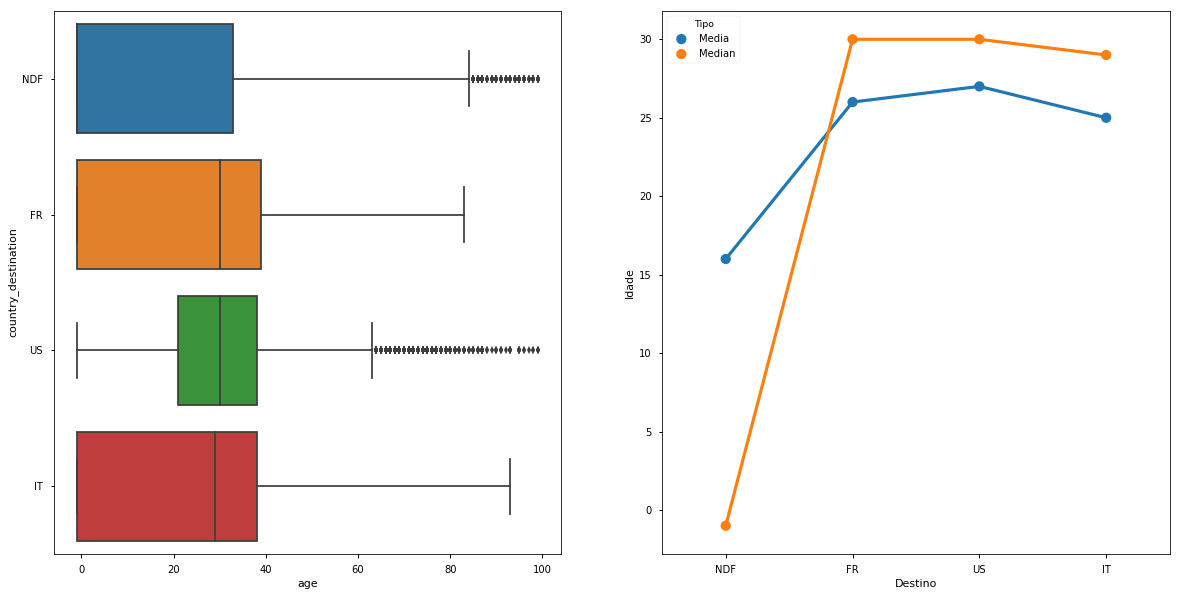

In [20]:
media = []
median = []
for pais in paises:
    media.append([pais, int(df_train.age[df_train['country_destination'] == pais].mean())])
    median.append([pais, int(df_train.age[df_train['country_destination'] == pais].median())])
media = pd.DataFrame(media)
media.columns = ['Destino','Idade']
media['Tipo'] = 'Media'
median = pd.DataFrame(median)
median.columns = ['Destino','Idade']
median['Tipo'] = 'Median'
media = pd.concat([media,median])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,10) )
sns.boxplot(x = df_train['age'], y = df_train.country_destination, ax= ax1)
sns.factorplot(x='Destino', y='Idade', hue = 'Tipo', data=media, kind = 'point', ax =ax2)
plt.close(2) 


* O grafico de linhas nos mostra que a idade é um fator fundamental na predição do Target ("NDF")

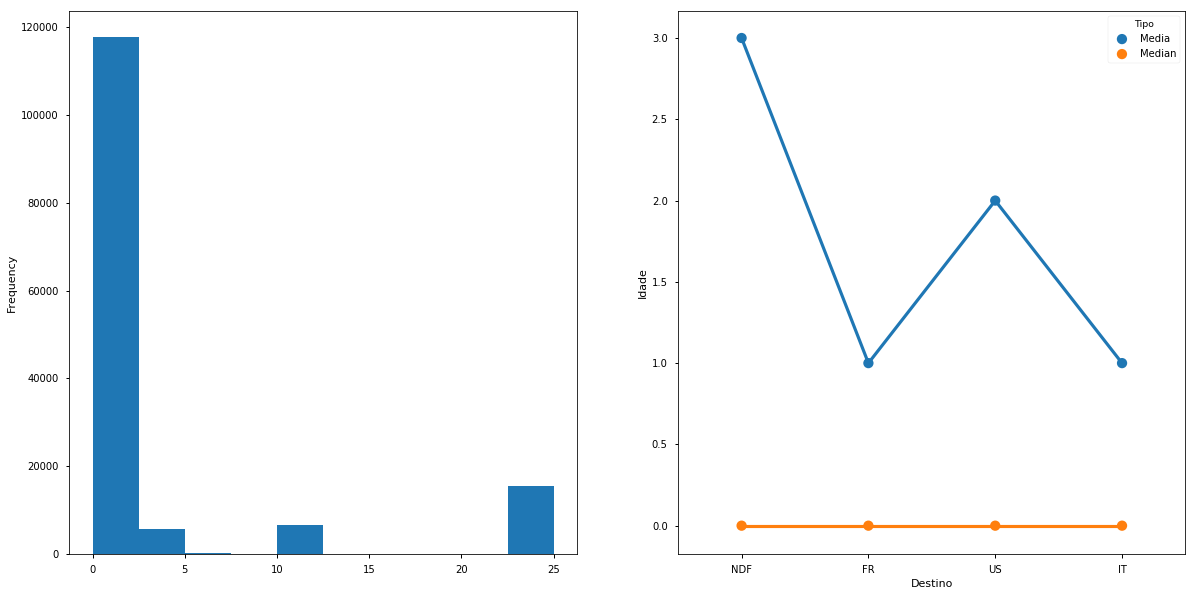

In [21]:
media = []
median = []
for pais in paises:
    media.append([pais, int(df_train.signup_flow[df_train['country_destination'] == pais].mean())])
    median.append([pais, int(df_train.signup_flow[df_train['country_destination'] == pais].median())])
media = pd.DataFrame(media)
media.columns = ['Destino','Idade']
media['Tipo'] = 'Media'
median = pd.DataFrame(median)
median.columns = ['Destino','Idade']
median['Tipo'] = 'Median'
media = pd.concat([media,median])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (20,10) )
df_train['signup_flow'].plot(kind ='hist', ax = ax1)
sns.factorplot(x='Destino', y='Idade', hue = 'Tipo', data=media, kind = 'point', ax =ax2)
plt.close(2)

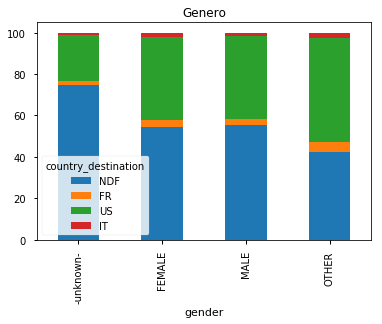

In [22]:
ctab = pd.crosstab([df_train['gender']], df_train.country_destination).apply(lambda x: (x/x.sum())*100, axis=1)
ctab[paises].plot(kind='bar', stacked = True, title = 'Genero')

In [23]:
# Classificação dos principais Browsers do mercado, os menos expressivos serão agrupados em uma unica categoria
browsers = df_train.groupby('first_browser').id.count().sort_values(ascending=False)
browsers = ['Chrome','Safari','Firefox','-unknown-','IE','Mobile Safari']
def browser(x):
    if x in browsers:
        return x
    else:
        x = 'Other'
        
df_train['Browser'] = df_train['first_browser'].map(browser)
df_test['Browser'] = df_test['first_browser'].map(browser)

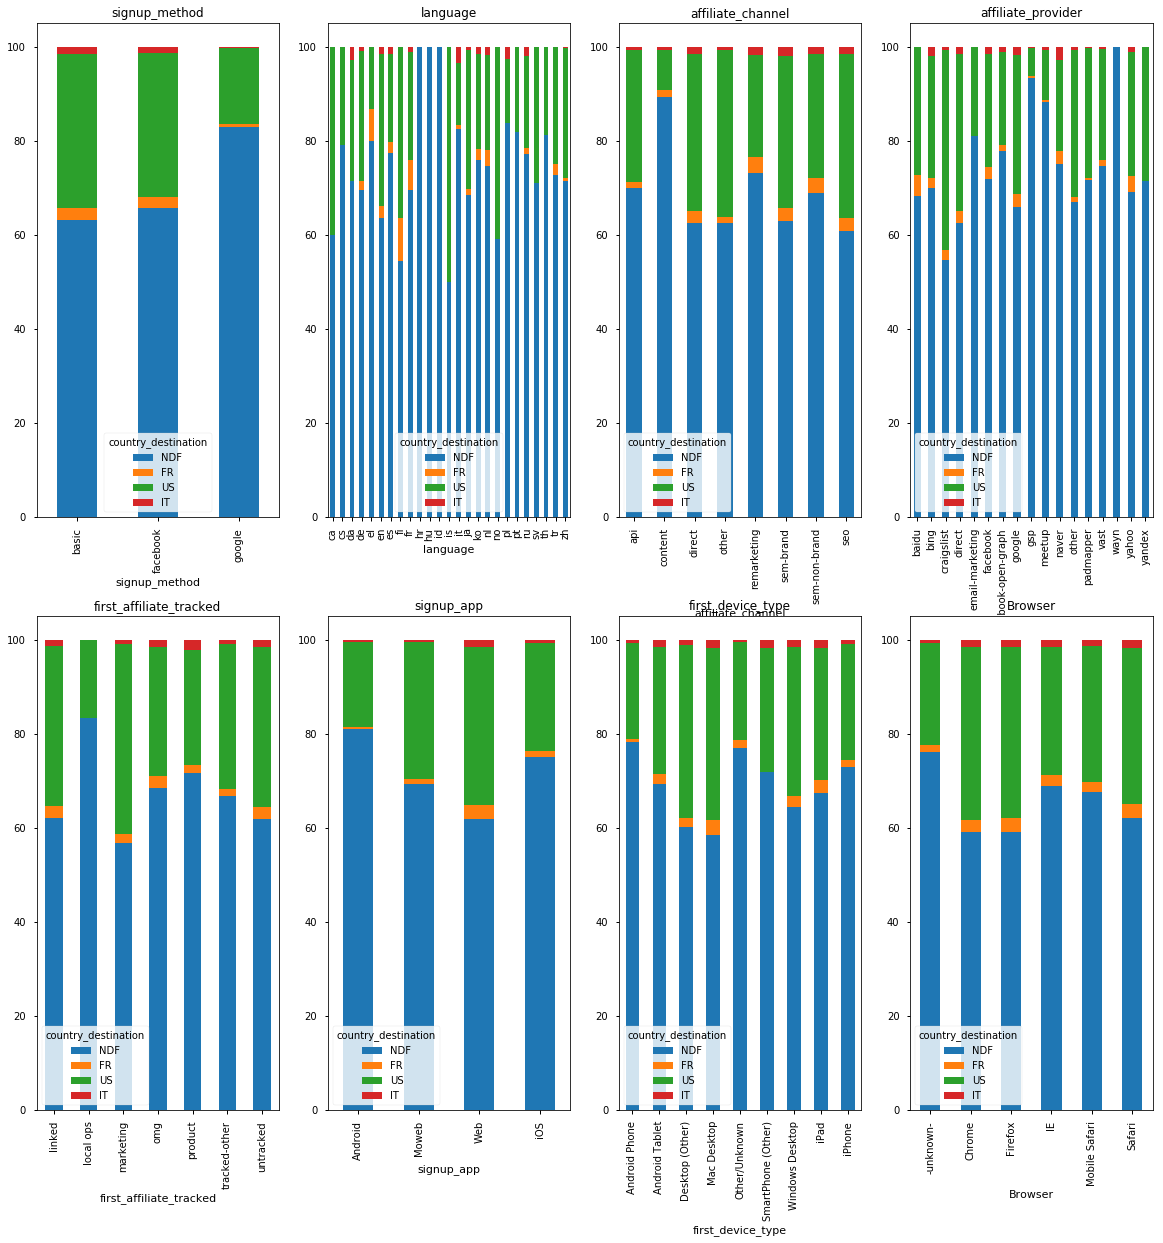

In [24]:
fig, ((ax1, ax2,ax3, ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows = 2, ncols = 4, figsize = (20,20))

colunas = []
lista =df_train.columns.values.tolist()
colunas.append(str(lista[6]))

for l in lista[8:14]:
    colunas.append(l)

colunas.append(str(lista[-1]))

ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
i = 0
for coluna in colunas:
    ctab = pd.crosstab([df_train[coluna]], df_train.country_destination).apply(lambda x: (x/x.sum())*100, axis=1)
    ctab[paises].plot(kind='bar', stacked = True, ax = ax[i], title = coluna)
    i += 1


# MODELO

In [25]:
df_train.columns

Index(['Unnamed: 0', 'id', 'date_account_created', 'timestamp_first_active',
       'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'tfa_dac', 'DIA', 'MES', 'ANO', 'DIASEMANA',
       'Browser'],
      dtype='object')

In [26]:
# importando as libs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import log_loss 
from sklearn import metrics

In [27]:
#Concatenando os dois sets para igual escolha de features
df_train['label'] = 'train'
df_test['label'] = 'test'

df_concat = pd.concat([df_train, df_test], axis=0)


In [28]:
#selecionando as features
#Enconding as features (Dummies)

df_concat = df_concat.loc(axis =1)['gender','age','signup_flow','language','affiliate_channel','affiliate_provider', 
                          'first_affiliate_tracked','signup_app', 'first_device_type', 
                          'DIA', 'MES', 'ANO', 'DIASEMANA', 'Browser','label']
gender= pd.get_dummies(df_concat.gender, prefix = 'gender')
language = pd.get_dummies(df_concat.language, prefix = 'language')
affiliate_channel = pd.get_dummies(df_concat.language, prefix = 'affiliate_channel')
affiliate_provider = pd.get_dummies(df_concat.language, prefix = 'affiliate_provider')
first_affiliate_tracked = pd.get_dummies(df_concat.language, prefix = 'first_affiliate_tracked')
signup_app = pd.get_dummies(df_concat.language, prefix = 'signup_app')
first_device_type = pd.get_dummies(df_concat.language, prefix = 'first_device_type')
DIASEMANA = pd.get_dummies(df_concat.language, prefix = 'DIASEMANA')
Browser = pd.get_dummies(df_concat.language, prefix = 'Browser')
df_concat = pd.concat([df_concat, gender, language,affiliate_channel, affiliate_provider,first_affiliate_tracked,signup_app,
               first_device_type, DIASEMANA, Browser],axis = 1)
df_concat = df_concat.drop(columns=['gender', 'language','affiliate_channel','affiliate_provider',
                    'first_affiliate_tracked','signup_app', 'first_device_type','DIASEMANA','Browser'])

In [29]:
#dividindo os 2 sets
X = df_concat[df_concat['label'] == 'train']
df_test = df_concat[df_concat['label'] == 'test']

X = X.drop('label', axis=1)
df_test = df_test.drop('label', axis=1)
df_train = df_train.drop('label', axis=1)

In [30]:
# Enconding o Target baseado no resultado pedido
def encoder(x):
    if x == 'NDF':
        encode = 0
    elif x == 'US':
        encode = 1
    elif x == 'FR':
        encode = 2
    else:
        encode = 3
    return encode    

y = df_train.loc(axis =1)['country_destination']

y = y.map(encoder)

In [31]:
#Dividindo entre set de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
#Setting lista de avaliação
aval = []

In [ ]:
#Regressão Logistica
from sklearn.linear_model import LogisticRegression
start = time.time()

clf = LogisticRegression()
clf.fit(X_train, y_train)

Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)


print('Train Score: {}'.format(clf.score(X_train, y_train)))
print('Test Score: {}'.format( metrics.accuracy_score(y_test, Y)))
print('Log_loss Score: {}'.format(score))
end = time.time()
print('time: {}'.format(end - start))

aval.append(['LogReg', score])

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

best = 100

for i in range(3, 21):
    
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(X_train, y_train)
    
    
    Y = clf.predict(X_test)
    Y_prob = clf.predict_proba(X_test)
    score = log_loss(y_test, Y_prob)
    if score < best: best = score
    
    print('Train Score Nº: {}, score: {}'.format(i,clf.score(X_train, y_train)))
    print('Test Score Nº: {}, score: {}'.format(i, metrics.accuracy_score(y_test, Y)))
    print('Log_loss Nº: {}, score: {}'.format(i, score))
    print('----------------------------------')
    
aval.append(['KNN', best])    

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

start = time.time()
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, y_train)

Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)


print('Train Score Nº: {}, score: {}'.format(i,clf.score(X_train, y_train)))
print('Test Score Nº: {}, score: {}'.format(i, metrics.accuracy_score(y_test, Y)))
print('Log_loss Nº: {}, core: {}'.format(i, score))

end = time.time()
print('time: {}'.format(end - start))

print('----------------------------------')

aval.append(['Decision', score])  

In [ ]:
#Ada Boost
from sklearn.ensemble import AdaBoostClassifier

start = time.time()
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7))
clf.fit(X_train, y_train)

clf.fit(X_train, y_train)
Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)

print('Train Score: {}'.format(clf.score(X_train, y_train)))
print('Test Score: {}'.format(metrics.accuracy_score(y_test, Y)))
print('Log_loss: {}'.format(score))

end = time.time()
print('time: {}'.format(end - start))

print('----------------------------------')

aval.append(['Ada', score])  

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

start = time.time()
clf = RandomForestClassifier(criterion='entropy', n_estimators = 1500, max_depth = 8)
clf.fit(X_train, y_train)

clf.fit(X_train, y_train)
Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)

print('Train Score Nº: {}, score: {}'.format(i,clf.score(X_train, y_train)))
print('Test Score Nº: {}, score: {}'.format(i, metrics.accuracy_score(y_test, Y)))
print('Log_loss Nº: {}, core: {}'.format(i, score))

end = time.time()
print('time: {}'.format(end - start))

print('----------------------------------')

aval.append(['Random', score])  

In [ ]:
"""#SVC   Devido ao SVC usar O^(n2-eps) para o processamento, fica inviavel utilizar 150k observações para aprendizado
from sklearn.svm import SVC

start = time.time() 
clf = SVC(probability=True) 
clf.fit(X_train, y_train)

clf.fit(X_train, y_train)
Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)

print('Train Score Nº: {}, score: {}'.format(i,clf.score(X_train, y_train)))
print('Test Score Nº: {}, score: {}'.format(i, metrics.accuracy_score(y_test, Y)))
print('Log_loss Nº: {}, core: {}'.format(i, score))

end = time.time()
print('time: {}'.format(end - start))

print('----------------------------------')

aval.append(['SVC', score])"""

In [ ]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

start = time.time()
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)


print('Train Score: {}'.format(clf.score(X_train, y_train)))
print('Test Score: {}'.format(metrics.accuracy_score(y_test, Y)))
print('Log_loss: {}'.format(score))
print('----------------------------------')
aval.append(['GBC', score])  

In [ ]:
#Escolhendo o algoritmo baseado no Log Loss
aval

## Tuning GBM
Após ser escolhido, iniciamos o processo de Tunning, que se dá por adicionar parâmetros afim de melhor a eficiência do algoritmo

In [ ]:
l_rates = [0.05,0.1,0.2]
n = 0
result = []
mostrar_resultado = False
for l_rate in l_rates:
    for n_est in range(60, 61, 10):
        for min_samp_split in range(100,801,100):
            for min_samp_leaf in range(100, 401, 20):
                n = n + 1   
                clf = GradientBoostingClassifier(learning_rate = l_rate, n_estimators = n_est, min_samples_split = min_samp_split, 
                                                min_samples_leaf = min_samp_leaf, max_depth = 8, max_features = 'sqrt')
                clf.fit(X_train, y_train)
                Y = clf.predict(X_test)
                Y_prob = clf.predict_proba(X_test)
                train_score = clf.score(X_train, y_train)
                test_score = metrics.accuracy_score(y_test, Y)
                score = log_loss(y_test, Y_prob)
                
                if mostrar_resultado:
                    print('TESTE Nº {}, learning_rate: {}, n_estimators: {}'.format(n ,l_rate,n_est))
                    print('Train Score: {}'.format(train_score))
                    print('Test Score: {}'.format(test_score))
                    print('Log_loss: {}'.format(score))
                    print('----------------------------------')
                result.append([n, l_rate, n_est, min_samp_split, min_samp_leaf, train_score, test_score, score])
                      
colunas = ['teste_n','learning_rate','estimators','min_samples_split','min_samples_leaf','train_score','test_score','logloss']
df_result = pd.DataFrame(result, columns = colunas)


In [ ]:
df_result = df_result.sort_values(by = ['logloss'], ascending = True)
df_result.head(10)

## Escolhendo o modelo

* Optamos pelo modelo Nº 1002 onde conseguimos o menor falor de Log Loss

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

start = time.time()
clf = GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 60, min_samples_split = 600, 
                                                min_samples_leaf = 120, max_depth = 8, max_features = 'sqrt')
clf.fit(X_train, y_train)
Y = clf.predict(X_test)
Y_prob = clf.predict_proba(X_test)
score = log_loss(y_test, Y_prob)


print('Train Score: {}'.format(clf.score(X_train, y_train)))
print('Test Score: {}'.format(metrics.accuracy_score(y_test, Y)))
print('Log_loss: {}'.format(score))
print('----------------------------------')

Train Score: 0.6718631629868292
Test Score: 0.6680539963308781
Log_loss: 0.7245775980222964
----------------------------------


Text(0,0.5,'Feature Importance Score')

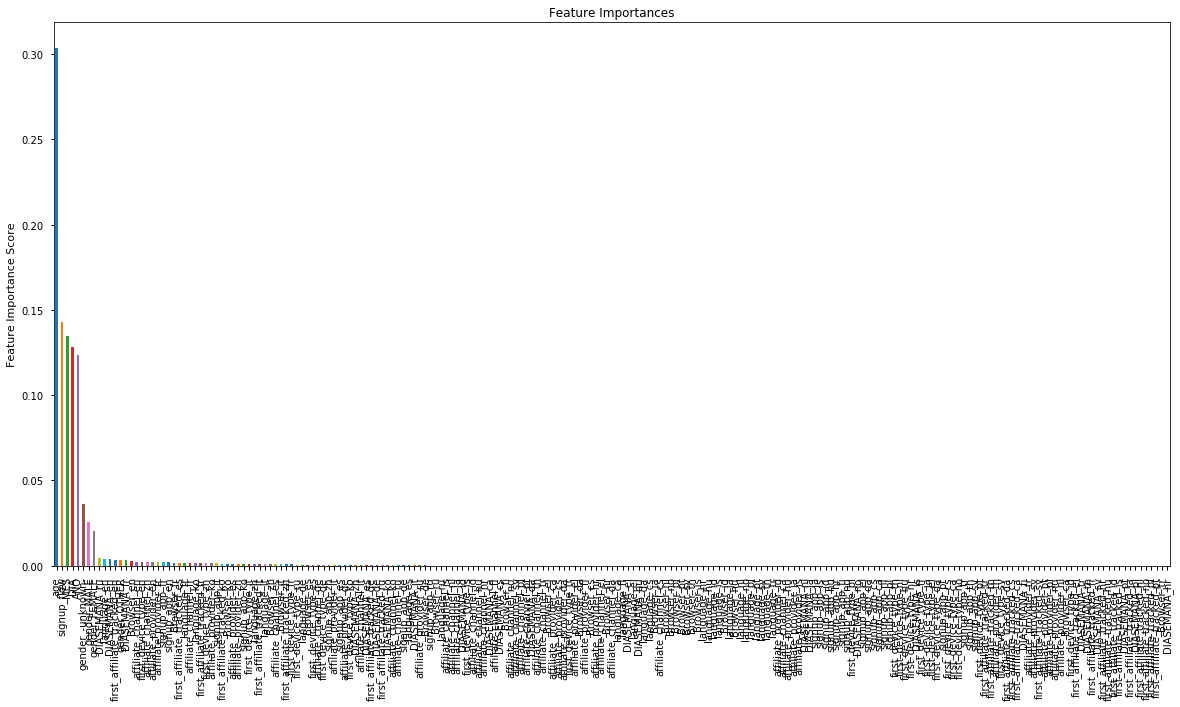

In [33]:
feat_imp = pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize = (20,10))
plt.ylabel('Feature Importance Score')

* Como esperado, a variavel (IDADE) é a mais importante na avaliação do modelo

# Utilizando o algoritmo para predição

## Pré-processamento do set de testes

In [ ]:
df_test.head()

In [ ]:
df_test.info()

In [35]:
#Inciando as predições
Y_prob_final = clf.predict_proba(df_test)

In [37]:
#Exportando resultados
result = pd.DataFrame(Y_prob_final)
result.to_csv('resultados_no_index.csv', index = False)